## Make OpenSearch Batches

In [ ]:
import pandas as pd
photos_df = pd.read_excel('SemanticSearch_photos.xlsx', header=0)

In [ ]:
photos_df

In [ ]:
len(photos_df)

In [ ]:
# Make excel files of size 10, 100, 1000, 10000, and then whatevers left.

photos_df.iloc[0:10].to_csv('SemanticSearch_photos_10.csv', index=False)
photos_df.iloc[10:110].to_csv('SemanticSearch_photos_100.csv', index=False)
photos_df.iloc[110:1110].to_csv('SemanticSearch_photos_1000.csv', index=False)
photos_df.iloc[1110:11110].to_csv('SemanticSearch_photos_10000.csv', index=False)
photos_df.iloc[11110:].to_csv('SemanticSearch_photos_10000plus.csv', index=False)

## Plotting graphs

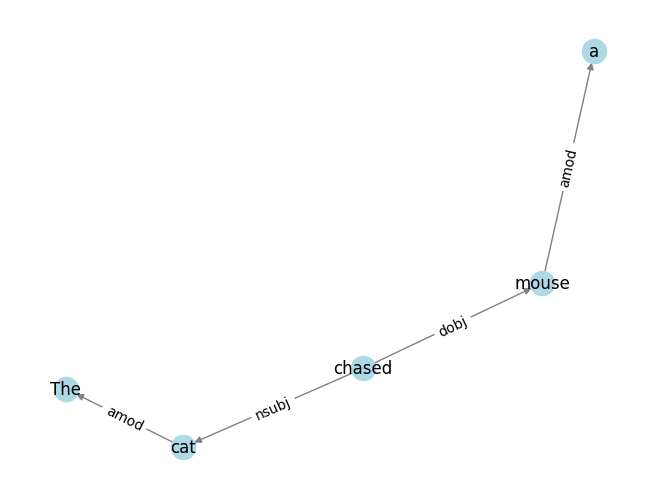

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the directed graph
G = nx.DiGraph()
dependencies = [
    {"dep": "nsubj", "governorGloss": "chased", "dependentGloss": "cat"},
    {"dep": "dobj", "governorGloss": "chased", "dependentGloss": "mouse"},
    {"dep": "amod", "governorGloss": "mouse", "dependentGloss": "a"},
    {"dep": "amod", "governorGloss": "cat", "dependentGloss": "The"}
]

for dep in dependencies:
    G.add_edge(dep["governorGloss"], dep["dependentGloss"], label=dep["dep"])

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'label')

nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()


# Running CoreNLP server

In [ ]:
!docker build -t spice-eval .

In [ ]:
!docker run -p 9000:9000 --name spice-container -d spice-eval

## Testing Spice graphs

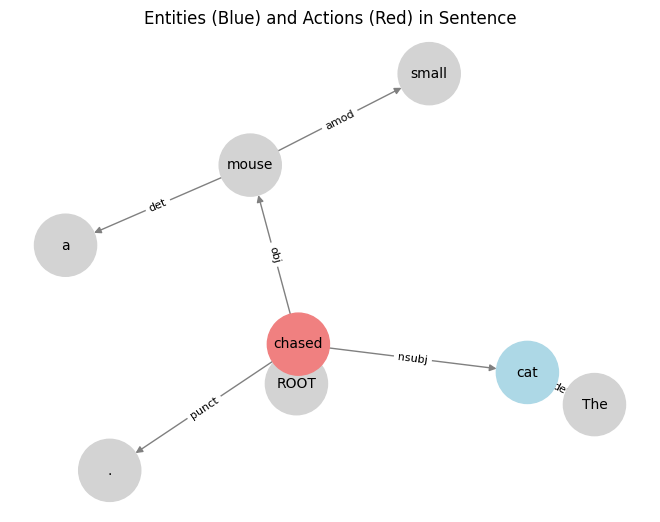

In [19]:
import requests
import networkx as nx
import matplotlib.pyplot as plt

# URL of the Stanford CoreNLP server running in your Docker container
CORENLP_URL = "http://localhost:9000"

def get_dependencies(sentence):
    """Send a sentence to CoreNLP and return the dependency graph."""
    params = {
        "annotators": "tokenize,ssplit,pos,depparse",
        "outputFormat": "json"
    }
    response = requests.post(f"{CORENLP_URL}/?properties={params}", data=sentence.encode("utf-8"))

    if response.status_code != 200:
        raise Exception(f"CoreNLP Error: {response.text}")

    parsed_data = response.json()
    return parsed_data["sentences"][0]["basicDependencies"]

def plot_dependency_graph(dependencies):
    """Plot the dependency graph with entities (blue) and actions (red)."""
    G = nx.DiGraph()
    
    entity_deps = {"nsubj", "dobj", "pobj", "nmod", "compound"}
    action_deps = {"root", "acl", "xcomp", "auxpass"}

    entities, actions = set(), set()

    for dep in dependencies:
        head = dep["governorGloss"]
        tail = dep["dependentGloss"]
        relation = dep["dep"]

        if relation in entity_deps:
            entities.add(tail)
        if relation in action_deps or head == "ROOT":
            actions.add(tail)

        G.add_edge(head, tail, label=relation)

    # Define node colors
    node_colors = []
    for node in G.nodes():
        if node in entities:
            node_colors.append("lightblue")  # Entities (nouns)
        elif node in actions:
            node_colors.append("lightcoral")  # Actions (verbs)
        else:
            node_colors.append("lightgray")  # Other words

    # Draw the graph
    pos = nx.spring_layout(G)
    labels = nx.get_edge_attributes(G, "label")

    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=2000, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

    plt.title("Entities (Blue) and Actions (Red) in Sentence")
    plt.show()

# Example caption
caption = "The cat chased a small mouse."

# Get dependencies from CoreNLP
dependencies = get_dependencies(caption)

# Plot the graph
plot_dependency_graph(dependencies)


## Remove punctuations

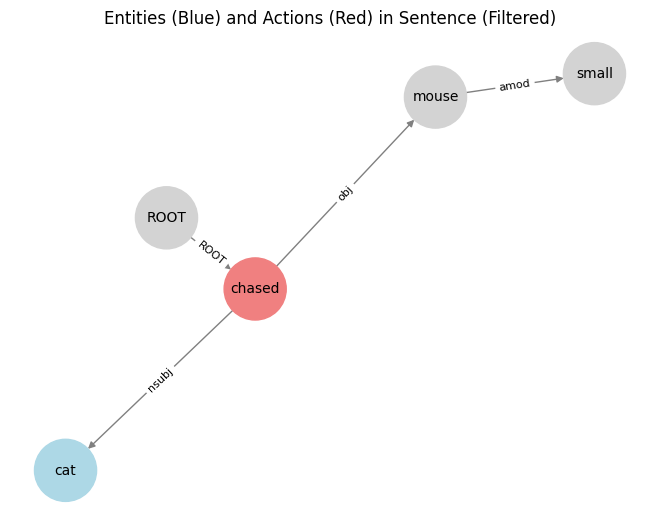

In [20]:
import requests
import networkx as nx
import matplotlib.pyplot as plt

CORENLP_URL = "http://localhost:9000"

# Define stopwords and punctuation POS tags
STOPWORDS = {"a", "an", "the", "some", "any"}
PUNCTUATION_TAGS = {".", ",", "''", "``", ":", "-LRB-", "-RRB-"}

def get_dependencies(sentence):
    """Send a sentence to CoreNLP and return dependency graph with POS tagging."""
    params = {
        "annotators": "tokenize,ssplit,pos,depparse",
        "outputFormat": "json"
    }
    response = requests.post(f"{CORENLP_URL}/?properties={params}", data=sentence.encode("utf-8"))

    if response.status_code != 200:
        raise Exception(f"CoreNLP Error: {response.text}")

    parsed_data = response.json()
    tokens = parsed_data["sentences"][0]["tokens"]
    dependencies = parsed_data["sentences"][0]["basicDependencies"]

    # Map words to their POS tags
    word_pos = {token["word"]: token["pos"] for token in tokens}

    return dependencies, word_pos

def plot_dependency_graph(dependencies, word_pos):
    """Plot dependency graph with entities (blue) and actions (red), ignoring stopwords/punctuation."""
    G = nx.DiGraph()
    
    entity_deps = {"nsubj", "dobj", "pobj", "nmod", "compound"}
    action_deps = {"root", "acl", "xcomp", "auxpass"}

    entities, actions = set(), set()

    for dep in dependencies:
        head = dep["governorGloss"]
        tail = dep["dependentGloss"]
        relation = dep["dep"]

        # Ignore punctuation and stopwords
        if (tail.lower() in STOPWORDS or word_pos.get(tail) in PUNCTUATION_TAGS or
            head.lower() in STOPWORDS or word_pos.get(head) in PUNCTUATION_TAGS):
            continue

        if relation in entity_deps:
            entities.add(tail)
        if relation in action_deps or head == "ROOT":
            actions.add(tail)

        G.add_edge(head, tail, label=relation)

    # Define node colors
    node_colors = []
    for node in G.nodes():
        if node in entities:
            node_colors.append("lightblue")  # Entities (nouns)
        elif node in actions:
            node_colors.append("lightcoral")  # Actions (verbs)
        else:
            node_colors.append("lightgray")  # Other words

    # Draw the graph
    pos = nx.spring_layout(G)
    labels = nx.get_edge_attributes(G, "label")

    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=2000, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

    plt.title("Entities (Blue) and Actions (Red) in Sentence (Filtered)")
    plt.show()

# Example caption
caption = "The cat chased a small mouse."

# Get dependencies from CoreNLP
dependencies, word_pos = get_dependencies(caption)

# Plot the graph
plot_dependency_graph(dependencies, word_pos)


## Lemmatize words

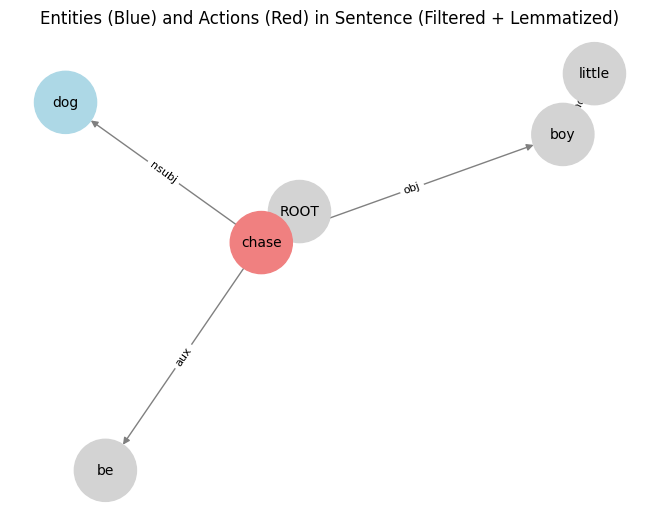

In [21]:
import requests
import networkx as nx
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

CORENLP_URL = "http://localhost:9000"

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define stopwords and punctuation POS tags
STOPWORDS = {"a", "an", "the", "some", "any"}
PUNCTUATION_TAGS = {".", ",", "''", "``", ":", "-LRB-", "-RRB-"}

def get_dependencies(sentence):
    """Send a sentence to CoreNLP and return dependency graph with POS tagging."""
    params = {
        "annotators": "tokenize,ssplit,pos,depparse",
        "outputFormat": "json"
    }
    response = requests.post(f"{CORENLP_URL}/?properties={params}", data=sentence.encode("utf-8"))

    if response.status_code != 200:
        raise Exception(f"CoreNLP Error: {response.text}")

    parsed_data = response.json()
    tokens = parsed_data["sentences"][0]["tokens"]
    dependencies = parsed_data["sentences"][0]["basicDependencies"]

    # Map words to their POS tags
    word_pos = {token["word"]: token["pos"] for token in tokens}

    return dependencies, word_pos

def lemmatize_word(word, pos):
    """Lemmatize word based on its POS tag (nouns and verbs)."""
    if pos.startswith("V"):  # Verb
        return lemmatizer.lemmatize(word, "v")
    elif pos.startswith("N"):  # Noun
        return lemmatizer.lemmatize(word, "n")
    return word  # Return unchanged for other types

def plot_dependency_graph(dependencies, word_pos):
    """Plot dependency graph with entities (blue) and actions (red), ignoring stopwords/punctuation."""
    G = nx.DiGraph()
    
    entity_deps = {"nsubj", "dobj", "pobj", "nmod", "compound"}
    action_deps = {"root", "acl", "xcomp", "auxpass"}

    entities, actions = set(), set()

    for dep in dependencies:
        raw_head = dep["governorGloss"]
        raw_tail = dep["dependentGloss"]
        relation = dep["dep"]

        # Ignore punctuation and stopwords
        if (raw_tail.lower() in STOPWORDS or word_pos.get(raw_tail) in PUNCTUATION_TAGS or
            raw_head.lower() in STOPWORDS or word_pos.get(raw_head) in PUNCTUATION_TAGS):
            continue

        # Get POS tags and lemmatize words
        head = lemmatize_word(raw_head, word_pos.get(raw_head, ""))
        tail = lemmatize_word(raw_tail, word_pos.get(raw_tail, ""))

        if relation in entity_deps:
            entities.add(tail)
        if relation in action_deps or head == "ROOT":
            actions.add(tail)

        G.add_edge(head, tail, label=relation)

    # Define node colors
    node_colors = []
    for node in G.nodes():
        if node in entities:
            node_colors.append("lightblue")  # Entities (nouns)
        elif node in actions:
            node_colors.append("lightcoral")  # Actions (verbs)
        else:
            node_colors.append("lightgray")  # Other words

    # Draw the graph
    pos = nx.spring_layout(G)
    labels = nx.get_edge_attributes(G, "label")

    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=2000, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

    plt.title("Entities (Blue) and Actions (Red) in Sentence (Filtered + Lemmatized)")
    plt.show()

# Example caption
caption = "The dogs were chasing a little boy."

# Get dependencies from CoreNLP
dependencies, word_pos = get_dependencies(caption)

# Plot the graph
plot_dependency_graph(dependencies, word_pos)


## Compare graphs and compute SPICE scores

In [38]:
import requests
import networkx as nx
from nltk.stem import WordNetLemmatizer

CORENLP_URL = "http://localhost:9000"

lemmatizer = WordNetLemmatizer()

STOPWORDS = {"a", "an", "the", "some", "any"}
PUNCTUATION_TAGS = {".", ",", "''", "``", ":", "-LRB-", "-RRB-"}

def get_dependencies(sentence):
    """Send a sentence to CoreNLP and return dependency graph."""
    params = {
        "annotators": "tokenize,ssplit,pos,depparse",
        "outputFormat": "json"
    }
    response = requests.post(f"{CORENLP_URL}/?properties={params}", data=sentence.encode("utf-8"))

    if response.status_code != 200:
        raise Exception(f"CoreNLP Error: {response.text}")

    parsed_data = response.json()
    tokens = parsed_data["sentences"][0]["tokens"]
    dependencies = parsed_data["sentences"][0]["basicDependencies"]
    
    word_pos = {token["word"]: token["pos"] for token in tokens}
    return dependencies, word_pos

def lemmatize_word(word, pos):
    """Lemmatize words based on POS tags."""
    if pos.startswith("V"):  
        return lemmatizer.lemmatize(word, "v")
    elif pos.startswith("N"):  
        return lemmatizer.lemmatize(word, "n")
    return word  

def build_scene_graph(dependencies, word_pos):
    """Create a scene graph from dependency relations."""
    G = nx.DiGraph()
    
    for dep in dependencies:
        raw_head = dep["governorGloss"]
        raw_tail = dep["dependentGloss"]
        relation = dep["dep"]

        if raw_tail.lower() in STOPWORDS or word_pos.get(raw_tail) in PUNCTUATION_TAGS:
            continue
        if raw_head.lower() in STOPWORDS or word_pos.get(raw_head) in PUNCTUATION_TAGS:
            continue

        head = lemmatize_word(raw_head, word_pos.get(raw_head, ""))
        tail = lemmatize_word(raw_tail, word_pos.get(raw_tail, ""))

        G.add_edge(head, tail, label=relation)

    return G

def graph_overlap(G1, G2):
    """Compute overlap (intersection) between two graphs."""
    edges1 = set(G1.edges)
    edges2 = set(G2.edges)

    print(edges1)
    print(edges2)

    intersection = edges1 & edges2
    return len(intersection), len(edges1), len(edges2)

def compute_spice(candidate, reference):
    """Compute SPICE score between two sentences."""
    dep1, pos1 = get_dependencies(candidate)
    dep2, pos2 = get_dependencies(reference)

    G1 = build_scene_graph(dep1, pos1)
    G2 = build_scene_graph(dep2, pos2)

    overlap, total_cand, total_ref = graph_overlap(G1, G2)

    precision = overlap / total_cand if total_cand > 0 else 0
    recall = overlap / total_ref if total_ref > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "precision": precision,
        "recall": recall,
        "F1-score": f1_score
    }

# Example Sentences
sentence1 = "A dog is chasing a cat."
sentence2 = "The dog runs after the cat."

# Compute SPICE
spice_score = compute_spice(sentence1, sentence2)

print(f"SPICE Score: {spice_score}")


{('ROOT', 'chase'), ('chase', 'be'), ('chase', 'cat'), ('chase', 'dog')}
{('run', 'dog'), ('run', 'cat'), ('ROOT', 'run'), ('cat', 'after')}
SPICE Score: {'precision': 0.0, 'recall': 0.0, 'F1-score': 0}


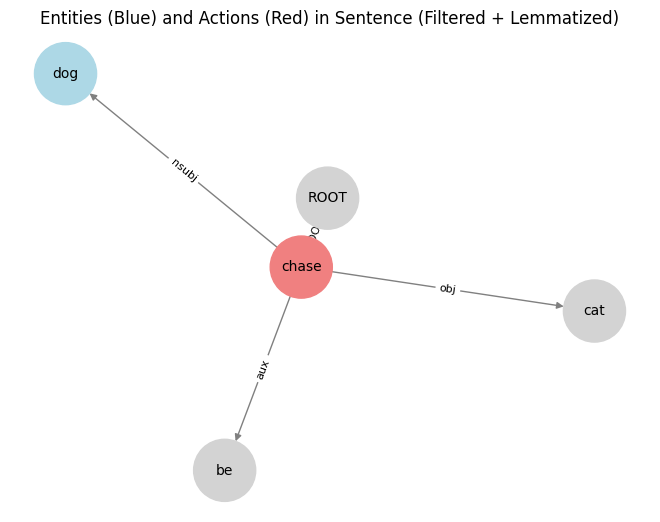

In [39]:
caption = "A dog is chasing a cat."

# Get dependencies from CoreNLP
dependencies, word_pos = get_dependencies(caption)
plot_dependency_graph(dependencies, word_pos)

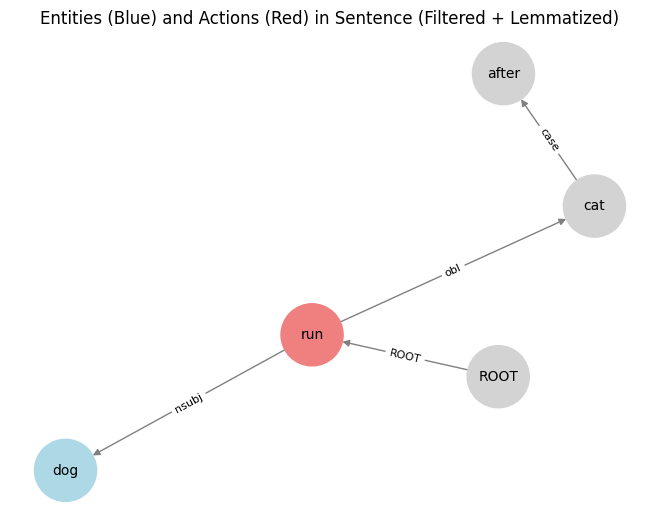

In [40]:
caption = "The dog runs after the cat."

# Get dependencies from CoreNLP
dependencies, word_pos = get_dependencies(caption)
plot_dependency_graph(dependencies, word_pos)

In [27]:
candidate = "A dog is chasing a cat."
dep1, pos1 = get_dependencies(candidate)
G1 = build_scene_graph(dep1, pos1)

In [36]:
set(G1.edges)

{('ROOT', 'chase'), ('chase', 'be'), ('chase', 'cat'), ('chase', 'dog')}

In [143]:
import requests
import json

import requests
import networkx as nx
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt

CORENLP_URL = "http://localhost:9000"
STOPWORDS = {"a", "an", "the", "some", "any"}
PUNCTUATION_TAGS = {".", ",", "''", "``", ":", "-LRB-", "-RRB-"}

lemmatizer = WordNetLemmatizer()

properties = {
    "annotators": "tokenize,pos,lemma,depparse",
    "outputFormat": "json",
    "split": "false"
}

ALLOWED_DEPS = {"nsubj", "dobj", "amod", "prep", "nmod", "root", "advmod", "compound", "acl", "xcomp", "auxpass","cop", "number", "nmod:poss","nmod:of", "nmod:in", "nmod:during", "obl:in", "mark" }

def are_synonyms(word1, word2):
    """Check if two words are synonyms using WordNet"""
    synsets1 = wordnet.synsets(word1)
    synsets2 = wordnet.synsets(word2)

    # Get all lemma names for each word
    synonyms1 = {lemma.name() for syn in synsets1 for lemma in syn.lemmas()}
    synonyms2 = {lemma.name() for syn in synsets2 for lemma in syn.lemmas()}

    # Check if they share any synonyms
    return bool(synonyms1 & synonyms2)

def match_with_synonyms(word1, word2):
    """Match words directly or through synonyms"""
    if word1 == word2:
        return True
    return are_synonyms(word1, word2)

def _get_dependencies(sentence):
    """Send a sentence to CoreNLP and return dependency graph."""
    response = requests.post(
        CORENLP_URL,
        params={"properties": json.dumps(properties)},
        data=sentence.encode("utf-8"),
        headers={"Content-Type": "text/plain"}
    )
    if response.status_code != 200:
        raise Exception(f"CoreNLP Error: {response.text}")

    parsed_data = response.json()
    tokens = parsed_data["sentences"][0]["tokens"]
    dependencies = parsed_data["sentences"][0]["basicDependencies"]
    
    word_pos = {token["word"]: token["pos"] for token in tokens}
    
    print("??????????????????????????????????????????")
    print(dependencies)
    print(word_pos)
    return dependencies, word_pos

def get_dependencies(sentence):
    """Send a sentence to CoreNLP and return dependency graph for all sentences."""
    response = requests.post(
        CORENLP_URL,
        params={"properties": json.dumps(properties)},
        data=sentence.encode("utf-8"),
        headers={"Content-Type": "text/plain"}
    )
    
    if response.status_code != 200:
        raise Exception(f"CoreNLP Error: {response.text}")

    parsed_data = response.json()
    scene_graph = []
    word_pos = {}

    deps = []

    for sentence_data in parsed_data["sentences"]:
        dependencies = sentence_data["enhancedDependencies"]
        triples = []

        for token in sentence_data["tokens"]:
            word_pos[token["word"].lower()] = token["pos"]

        for dep in dependencies:
            if dep["dep"] in ALLOWED_DEPS: 

                triples.append({
                    "governorGloss": dep["governorGloss"].lower(),
                    "dep": dep["dep"].lower(),
                    "dependentGloss": dep["dependentGloss"].lower()
                })
            deps.append(dep["dep"])

        scene_graph.extend(triples)

    print("??????????????????????????????????????????")
    print(set(deps))
    print(scene_graph)
    print(word_pos)

    return scene_graph, word_pos

def lemmatize_word(word, pos):
    """Lemmatize words based on POS tags."""
    if pos.startswith("V"):  
        return lemmatizer.lemmatize(word, "v")
    elif pos.startswith("N"):  
        return lemmatizer.lemmatize(word, "n")
    return word  

def build_scene_graph(dependencies, word_pos):
    """Create a scene graph from dependency relations."""
    G = nx.DiGraph()
    
    for dep in dependencies:
        raw_head = dep["governorGloss"]
        raw_tail = dep["dependentGloss"]
        relation = dep["dep"]

        # TODO: Filter out words less than or equal to 2 characters
        if raw_tail.lower() in STOPWORDS or word_pos.get(raw_tail) in PUNCTUATION_TAGS or len(raw_tail) <= 2:
            continue
        if raw_head.lower() in STOPWORDS or word_pos.get(raw_head) in PUNCTUATION_TAGS or len(raw_head) <= 2:
            continue

        head = lemmatize_word(raw_head, word_pos.get(raw_head, ""))
        tail = lemmatize_word(raw_tail, word_pos.get(raw_tail, ""))

        G.add_edge(head, tail, label=relation)

    return G

def plot_dependency_graph(dependencies, word_pos, additional_tags=""):
    """Plot dependency graph with entities (blue) and actions (red), ignoring stopwords/punctuation."""
    
    ## Clean plt
    plt.clf()
    G = nx.DiGraph()
    
    entity_deps = {"nsubj", "dobj", "pobj", "nmod", "compound", "amod", "prep"}
    action_deps = {"root", "acl", "xcomp", "auxpass", "advmod", }

    entities, actions = set(), set()

    for dep in dependencies:
        raw_head = dep["governorGloss"]
        raw_tail = dep["dependentGloss"]
        relation = dep["dep"]

        # Ignore punctuation and stopwords
        if (raw_tail.lower() in STOPWORDS or word_pos.get(raw_tail) in PUNCTUATION_TAGS or
            raw_head.lower() in STOPWORDS or word_pos.get(raw_head) in PUNCTUATION_TAGS)  or len(raw_tail) <= 2 or len(raw_head) <= 2:
            continue

        # Get POS tags and lemmatize words
        head = lemmatize_word(raw_head, word_pos.get(raw_head, ""))
        tail = lemmatize_word(raw_tail, word_pos.get(raw_tail, ""))

        if relation in entity_deps:
            entities.add(tail)
        if relation in action_deps or head == "ROOT":
            actions.add(tail)

        G.add_edge(head, tail, label=relation)

    # Define node colors
    node_colors = []
    for node in G.nodes():
        if node in entities:
            node_colors.append("lightblue")  # Entities (nouns)
        elif node in actions:
            node_colors.append("lightcoral")  # Actions (verbs)
        else:
            node_colors.append("lightgray")  # Other words

    print(G.nodes())

    # Draw the graph
    # pos = nx.spring_layout(G)
    # pos = nx.kamada_kawai_layout(G)
    # pos = nx.spectral_layout(G)
    pos = nx.spring_layout(G)
    labels = nx.get_edge_attributes(G, "label")

    plt.figure(figsize=(10, 7))  # Make the figure larger

    #nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=2000, font_size=10)
    #nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=2500, font_size=12, font_weight="bold", edgecolors="black")

    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=10, font_color="black", bbox=dict(facecolor="white", edgecolor="none", alpha=0.7))


    plt.title(f"Entities (Blue) and Actions (Red) in Sentence (Filtered + Lemmatized), {additional_tags}")
    plt.show()

def get_spice_score(caption1, caption2, corenlp_url="http://localhost:9000", plot=False):
    # Define parameters for CoreNLP
    def get_scene_graph(caption):
        response = requests.post(
            CORENLP_URL,
            params={"properties": json.dumps(properties)},
            data=caption.encode("utf-8"),
            headers={"Content-Type": "text/plain"}
        )
        
        if response.status_code != 200:
            raise Exception("Error processing caption with CoreNLP")
        
        parsed_data = response.json()
        scene_graph = []
        
        
        for sentence in parsed_data["sentences"]:
            dependencies = sentence["enhancedDependencies"]
            triples = []
            for dep in dependencies:
                if dep["dep"] in ALLOWED_DEPS: 
                    triples.append((dep["governorGloss"].lower(), dep["dep"].lower(), dep["dependentGloss"].lower()))
            scene_graph.append(triples)
        
        return scene_graph
    
    sg1 = get_scene_graph(caption1)
    sg2 = get_scene_graph(caption2)
    
    print(sg1)
    print(sg2)
    
    # Calculate SPICE precision, recall, and F1 score
    sg1_set = set(tuple(triple) for sentence in sg1 for triple in sentence)
    sg2_set = set(tuple(triple) for sentence in sg2 for triple in sentence)

    # matching_triples = len(sg1_set & sg2_set)  # Intersection of sets
    matching_triples = sum(
        1 for triple1 in sg1_set for triple2 in sg2_set 
        if match_with_synonyms(triple1[0], triple2[0]) and  # Match governor word
        triple1[1] == triple2[1] and                    # Exact relation match
        match_with_synonyms(triple1[2], triple2[2])     # Match dependent word
    )
    precision = matching_triples / max(len(sg1_set), 1)
    recall = matching_triples / max(len(sg2_set), 1)
    
    if plot:
        dependencies1, word_pos1 = get_dependencies(caption1)
        plot_dependency_graph(dependencies1, word_pos1, additional_tags="Caption 1")
        dependencies2, word_pos2 = get_dependencies(caption2)
        plot_dependency_graph(dependencies2, word_pos2, additional_tags="Caption 2")
        
        print(dependencies1)
        print(dependencies2)
    
    if precision + recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
    
    return {
        "precision": precision,
        "recall": recall,
        "spice_score": f1_score
    }

# Example Usage
caption1 = "A dog is playing in the park."
caption2 = "A puppy runs through a green field."

# TODO: Noun or action synonyms?

spice_result = get_spice_score(caption1, caption2)
print(spice_result)

[[('playing', 'nsubj', 'dog'), ('playing', 'obl:in', 'park')]]
[[('runs', 'nsubj', 'puppy'), ('field', 'amod', 'green')]]
{'precision': 0.0, 'recall': 0.0, 'spice_score': 0.0}


In [144]:
# Example Usage
caption1 = "Australia's Dyson Daniels dunks the ball during an exhibition basketball match between Australia and Serbia at the USA Basketball Showcase, ahead of the 2024 Paris Olympic basketball tournament, in Abu Dhabi, United Arab Emirates, Tuesday, July 16, 2024. (AP Photo/Altaf Qadri)"
caption2 = 'Wide shot of a basketball game in Abu Dhabi, featuring Dyson Daniels from Australia dunking the ball. He wears a green jersey with "AUSTRALIA" and number 1 visible. Below him, Serbian players in white jerseys with "SERBIA" and names like "MICIC" and "GUDURIĆ" watch. The basketball rim and backboard are visible, with a USA Basketball logo. The background shows a filled stadium with spectators, mostly in dark clothing. The lighting highlights the court action, with the audience slightly blurred. The setting is part of the USA Basketball Showcase, ahead of the 2024 Paris Olympic basketball tournament'

spice_result = get_spice_score(caption1, caption2)
print(spice_result)

[[('daniels', 'nmod:poss', 'australia'), ('daniels', 'compound', 'dyson'), ('dunks', 'nsubj', 'daniels'), ('match', 'compound', 'exhibition'), ('match', 'compound', 'basketball'), ('basketball', 'compound', 'usa'), ('showcase', 'compound', 'basketball'), ('dunks', 'advmod', 'ahead'), ('tournament', 'compound', 'paris'), ('basketball', 'compound', 'olympic'), ('tournament', 'compound', 'basketball'), ('dhabi', 'compound', 'abu'), ('dunks', 'obl:in', 'dhabi'), ('emirates', 'compound', 'united'), ('emirates', 'compound', 'arab'), ('tuesday', 'amod', '2024')], [('qadri', 'compound', 'ap'), ('qadri', 'compound', 'photo'), ('qadri', 'compound', 'altaf')]]
[[('shot', 'amod', 'wide'), ('game', 'compound', 'basketball'), ('shot', 'nmod:of', 'game'), ('dhabi', 'compound', 'abu'), ('shot', 'nmod:in', 'dhabi'), ('shot', 'acl', 'featuring'), ('daniels', 'compound', 'dyson'), ('daniels', 'acl', 'dunking')], [('wears', 'nsubj', 'he'), ('jersey', 'amod', 'green'), ('number', 'amod', 'visible')], [('hi

In [145]:
# Example Usage
caption1 = "Dean Bombac, center, of Slovenia, plays against Miguel Sanchez-Migallon of Spain during a men's handball match at the 2024 Summer Olympics, Saturday, July 27, 2024, in Paris, France. (AP Photo/Aaron Favila)"
caption2 = "Wide shot of a men's handball match during the 2024 Summer Olympics in Paris. Dean Bombac of Slovenia, wearing a white and blue uniform, is at the center, actively engaging with Miguel Sanchez-Migallon of Spain, in a red and black uniform. Bombac holds the ball in his right hand, while Sanchez-Migallon attempts to block him with his left arm. Another player in a white uniform is visible in the background. The audience is partially visible in the blurred background. The floor is a shade of green, and the atmosphere is dynamic and competitive."

spice_result = get_spice_score(caption1, caption2)
print(spice_result)


[[('bombac', 'compound', 'dean'), ('plays', 'nsubj', 'bombac'), ('bombac', 'nmod:of', 'slovenia'), ('migallon', 'compound', 'miguel'), ('migallon', 'compound', 'sanchez'), ('migallon', 'nmod:of', 'spain'), ('match', 'nmod:poss', 'men'), ('match', 'compound', 'handball'), ('olympics', 'compound', 'summer'), ('saturday', 'amod', '2024'), ('saturday', 'nmod:in', 'paris')], [('favila', 'compound', 'ap'), ('favila', 'compound', 'photo'), ('favila', 'compound', 'aaron')]]
[[('shot', 'amod', 'wide'), ('match', 'nmod:poss', 'men'), ('match', 'compound', 'handball'), ('shot', 'nmod:of', 'match'), ('olympics', 'compound', 'summer'), ('shot', 'nmod:during', 'olympics'), ('olympics', 'nmod:in', 'paris')], [('bombac', 'compound', 'dean'), ('center', 'nsubj', 'bombac'), ('bombac', 'nmod:of', 'slovenia'), ('bombac', 'acl', 'wearing'), ('uniform', 'amod', 'white'), ('uniform', 'amod', 'blue'), ('center', 'cop', 'is'), ('engaging', 'advmod', 'actively'), ('center', 'acl', 'engaging'), ('migallon', 'com

In [146]:
# SPICE Benchmark: https://paperswithcode.com/sota/image-captioning-on-coco-captions

[[('bombac', 'compound', 'dean'), ('plays', 'nsubj', 'bombac'), ('bombac', 'nmod:of', 'slovenia'), ('migallon', 'compound', 'miguel'), ('migallon', 'compound', 'sanchez'), ('migallon', 'nmod:of', 'spain'), ('match', 'nmod:poss', 'men'), ('match', 'compound', 'handball'), ('olympics', 'compound', 'summer'), ('saturday', 'amod', '2024'), ('saturday', 'nmod:in', 'paris')], [('favila', 'compound', 'ap'), ('favila', 'compound', 'photo'), ('favila', 'compound', 'aaron')]]
[[('shot', 'amod', 'wide'), ('match', 'nmod:poss', 'men'), ('match', 'compound', 'handball'), ('shot', 'nmod:of', 'match'), ('olympics', 'compound', 'summer'), ('shot', 'nmod:during', 'olympics'), ('olympics', 'nmod:in', 'paris')], [('bombac', 'compound', 'dean'), ('center', 'nsubj', 'bombac'), ('bombac', 'nmod:of', 'slovenia'), ('bombac', 'acl', 'wearing'), ('uniform', 'amod', 'white'), ('uniform', 'amod', 'blue'), ('center', 'cop', 'is'), ('engaging', 'advmod', 'actively'), ('center', 'acl', 'engaging'), ('migallon', 'com

<Figure size 640x480 with 0 Axes>

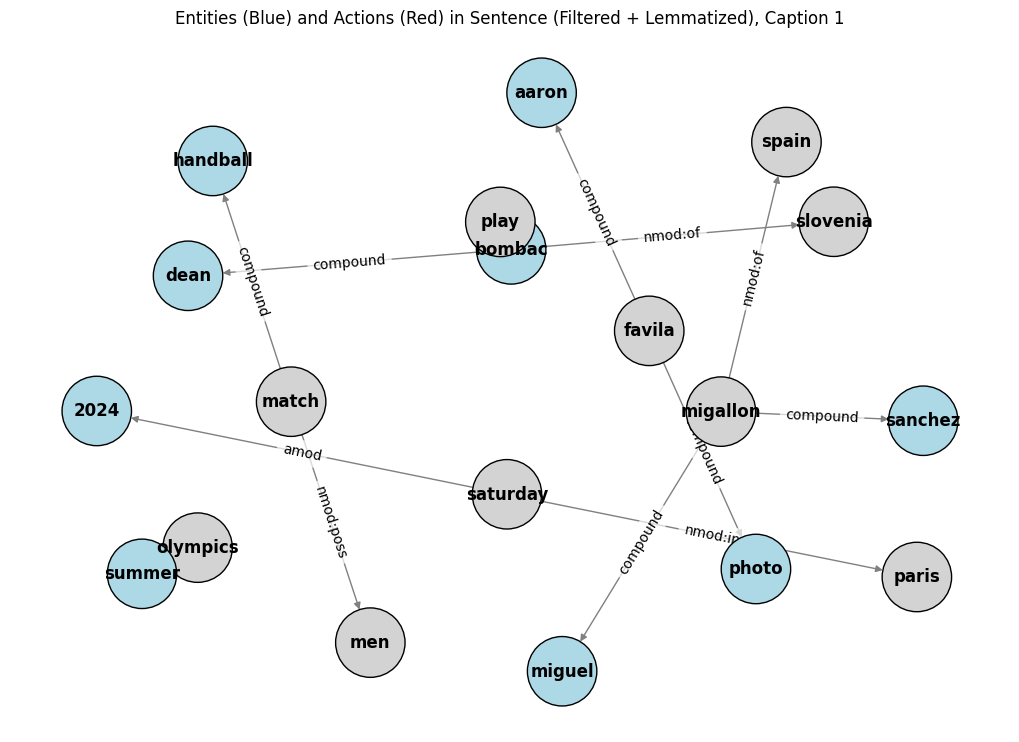

??????????????????????????????????????????
{'obj', 'nmod:of', 'obl:with', 'conj:and', 'nummod', 'compound', 'nmod:in', 'punct', 'amod', 'nmod:during', 'det', 'cop', 'nsubj', 'advcl:while', 'ROOT', 'mark', 'nmod:poss', 'xcomp', 'case', 'nsubj:xsubj', 'cc', 'acl', 'advmod', 'obl:in'}
[{'governorGloss': 'shot', 'dep': 'amod', 'dependentGloss': 'wide'}, {'governorGloss': 'match', 'dep': 'nmod:poss', 'dependentGloss': 'men'}, {'governorGloss': 'match', 'dep': 'compound', 'dependentGloss': 'handball'}, {'governorGloss': 'shot', 'dep': 'nmod:of', 'dependentGloss': 'match'}, {'governorGloss': 'olympics', 'dep': 'compound', 'dependentGloss': 'summer'}, {'governorGloss': 'shot', 'dep': 'nmod:during', 'dependentGloss': 'olympics'}, {'governorGloss': 'olympics', 'dep': 'nmod:in', 'dependentGloss': 'paris'}, {'governorGloss': 'bombac', 'dep': 'compound', 'dependentGloss': 'dean'}, {'governorGloss': 'center', 'dep': 'nsubj', 'dependentGloss': 'bombac'}, {'governorGloss': 'bombac', 'dep': 'nmod:of', 

<Figure size 640x480 with 0 Axes>

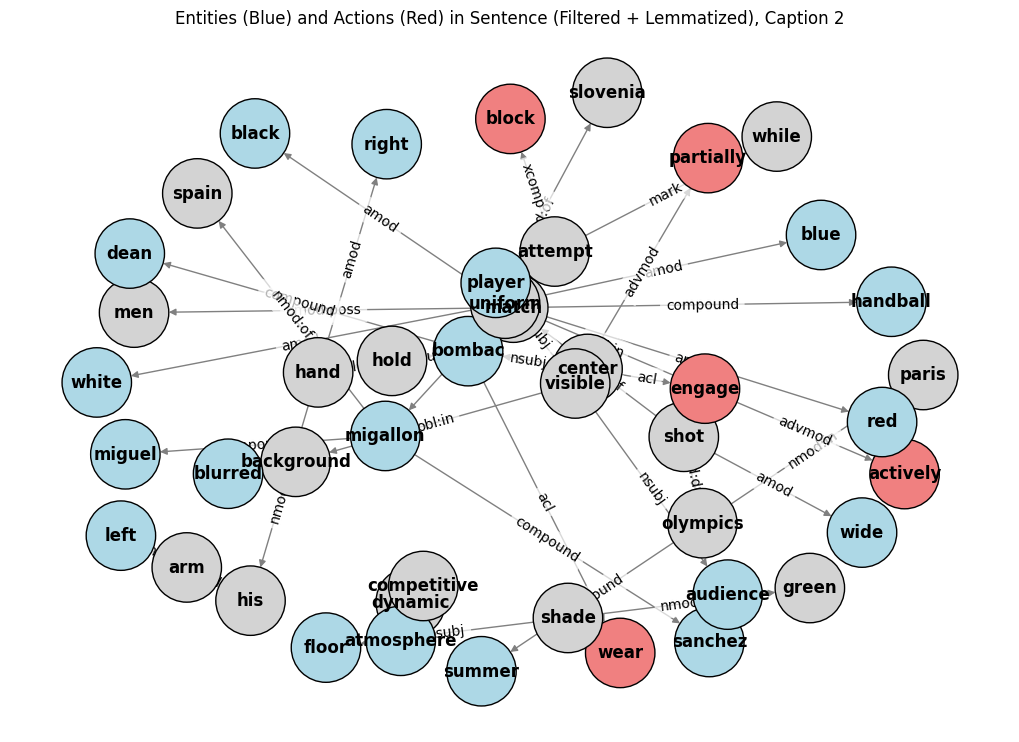

[{'governorGloss': 'bombac', 'dep': 'compound', 'dependentGloss': 'dean'}, {'governorGloss': 'plays', 'dep': 'nsubj', 'dependentGloss': 'bombac'}, {'governorGloss': 'bombac', 'dep': 'nmod:of', 'dependentGloss': 'slovenia'}, {'governorGloss': 'migallon', 'dep': 'compound', 'dependentGloss': 'miguel'}, {'governorGloss': 'migallon', 'dep': 'compound', 'dependentGloss': 'sanchez'}, {'governorGloss': 'migallon', 'dep': 'nmod:of', 'dependentGloss': 'spain'}, {'governorGloss': 'match', 'dep': 'nmod:poss', 'dependentGloss': 'men'}, {'governorGloss': 'match', 'dep': 'compound', 'dependentGloss': 'handball'}, {'governorGloss': 'olympics', 'dep': 'compound', 'dependentGloss': 'summer'}, {'governorGloss': 'saturday', 'dep': 'amod', 'dependentGloss': '2024'}, {'governorGloss': 'saturday', 'dep': 'nmod:in', 'dependentGloss': 'paris'}, {'governorGloss': 'favila', 'dep': 'compound', 'dependentGloss': 'ap'}, {'governorGloss': 'favila', 'dep': 'compound', 'dependentGloss': 'photo'}, {'governorGloss': 'f

In [147]:
# Example Usage
caption1 = "Dean Bombac, center, of Slovenia, plays against Miguel Sanchez-Migallon of Spain during a men's handball match at the 2024 Summer Olympics, Saturday, July 27, 2024, in Paris, France. (AP Photo/Aaron Favila)"
caption2 = "Wide shot of a men's handball match during the 2024 Summer Olympics in Paris. Dean Bombac of Slovenia, wearing a white and blue uniform, is at the center, actively engaging with Miguel Sanchez-Migallon of Spain, in a red and black uniform. Bombac holds the ball in his right hand, while Sanchez-Migallon attempts to block him with his left arm. Another player in a white uniform is visible in the background. The audience is partially visible in the blurred background. The floor is a shade of green, and the atmosphere is dynamic and competitive."

spice_result = get_spice_score(caption1, caption2, plot=True)
print(spice_result)

## Create an evaluation dataset

In [ ]:
import fetch_random_image_metadata
import pandas as pd

desired_batch_size = 8000

image_caption_sample = {
    "image_key": [],
    "title": [], 
    "caption": [],
    "alt_text": []
}
count = 0
while len(image_caption_sample["image_key"]) < desired_batch_size:
    random_image_metadata = fetch_random_image_metadata.test_random_image_return()
    if random_image_metadata["alt_text"] == "No alt-text available.":
        continue
        
    image_caption_sample["image_key"].append(random_image_metadata["image_key"])
    image_caption_sample["title"].append(random_image_metadata["title"])
    image_caption_sample["caption"].append(random_image_metadata["caption"])
    image_caption_sample["alt_text"].append(random_image_metadata["alt_text"])
    count += 1
    if count % 100 == 0:
        print(count)


In [ ]:
import fetch_random_image_metadata
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing

desired_batch_size = 8000

image_caption_sample = {
    "image_key": [],
    "title": [], 
    "caption": [],
    "alt_text": []
}

def fetch_and_filter_metadata():
    while True:
        random_image_metadata = fetch_random_image_metadata.test_random_image_return()
        if random_image_metadata["alt_text"] != "No alt-text available.":
            return random_image_metadata


count = 0
with ThreadPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
    futures = [executor.submit(fetch_and_filter_metadata) for _ in range(desired_batch_size)]
    for future in as_completed(futures):
        random_image_metadata = future.result()
        image_caption_sample["image_key"].append(random_image_metadata["image_key"])
        image_caption_sample["title"].append(random_image_metadata["title"])
        image_caption_sample["caption"].append(random_image_metadata["caption"])
        image_caption_sample["alt_text"].append(random_image_metadata["alt_text"])
        count += 1
        if count % 100 == 0:
            print(count)
        if len(image_caption_sample["image_key"]) >= desired_batch_size:
            break


## Running spice.py on a dataset

In [6]:
import pandas as pd

dataset_for_evaluation = pd.read_excel("image_captions_fore_valuation.xlsx")
dataset_for_evaluation.head() # columns should be: "image_key", "title" "caption" "alt_text"

,image_key,title,caption,alt_text
0,photos_for_semantic_search_poc/1528d961348c438...,Paris Olympics Table Tennis,"Cuba's Jorge Campos, with her teammate Daniela...","Close-up shot of a table tennis player, identi..."
1,photos_for_semantic_search_poc/149582a31adb437...,Paris Olympics Soccer,Canada stand-in coach Andy Spence talks to Clo...,Mid-shot of Canada stand-in coach Andy Spence ...
2,photos_for_semantic_search_poc/01ca71a925e342b...,Paris Olympics Water Polo,Croatia's Luka Loncar scores a goal during a m...,Mid-shot of a water polo match during the 2024...
3,photos_for_semantic_search_poc/00aaf8a923e14e7...,Paris Olympics Soccer,"Uzbekistan's Jasurbek Jaloliddinov, left, take...",Wide shot of a soccer match at Parc des Prince...
4,photos_for_semantic_search_poc/131044787c94452...,Paris Olympics Beach Volleyball,Nina Brunner reaches the ball during the women...,"A mid-shot captures Nina Brunner, wearing a bl..."


In [ ]:
from spice import get_spice_score
from tqdm.notebook import tqdm

precisions, recalls, f1_scores = [], [], []
caption_dependencies, alt_text_dependencies = [], []
caption_word_pos, alt_text_word_pos = [], []

for index, row in tqdm(dataset_for_evaluation.iterrows(), total=len(dataset_for_evaluation)):
    caption = row["caption"]
    alt_text = row["alt_text"]
    spice_result = get_spice_score(caption, alt_text)
    # Expect output in the following format
    # {
    #     "metrcs": {"precision": precision, "recall": recall, "spice_score": f1_score},
    #     "caption_1": {
    #         "dependencies": sg1,
    #         "word_pos": word_pos1,
    #     },  # Dependency graph and POS tags
    #     "caption_2": {
    #         "dependencies": sg2,
    #         "word_pos": word_pos2,
    #     },
    # }
    precisions.append(spice_result["metrics"]["precision"])
    recalls.append(spice_result["metrics"]["recall"])
    f1_scores.append(spice_result["metrics"]["spice_score"])
    caption_dependencies.append(spice_result["caption_1"]["dependencies"])
    caption_word_pos.append(spice_result["caption_1"]["word_pos"])
    alt_text_dependencies.append(spice_result["caption_2"]["dependencies"])
    alt_text_word_pos.append(spice_result["caption_2"]["word_pos"])
    
    
dataset_for_evaluation["precision"] = precisions
dataset_for_evaluation["recall"] = recalls
dataset_for_evaluation["f1_score"] = f1_scores
dataset_for_evaluation["caption_dependencies"] = caption_dependencies
dataset_for_evaluation["caption_word_pos"] = caption_word_pos
dataset_for_evaluation["alt_text_dependencies"] = alt_text_dependencies
dataset_for_evaluation["alt_text_word_pos"] = alt_text_word_pos


In [ ]:

dataset_for_evaluation.to_excel("image_captions_fore_valuation_with_spice_scores.xlsx", index=False)

## Display the graph of a given image_key and it's scores

In [14]:
import ast
import pandas as pd
from spice import plot_dependency_graph
from IPython.display import display as IPDisplay, Image as IPImage
from utils import download_image_from_s3, get_random_image, bucket_name


evaluated_dataset = pd.read_excel("image_captions_fore_valuation_with_spice_scores.xlsx")


def get_scores(image_key: str, plot=False, display=False):
    row = evaluated_dataset[evaluated_dataset["image_key"] == image_key]
    if row.empty:
        return None

    caption = row["caption"].values[0]
    alt_text = row["alt_text"].values[0]

    if display:
        image_data = download_image_from_s3(bucket_name, image_key)
        IPDisplay(IPImage(data=image_data))

    if plot:
        caption_dependencies = ast.literal_eval(row["caption_dependencies"].values[0])
        caption_word_pos = ast.literal_eval(row["caption_word_pos"].values[0])
        alt_text_dependencies = ast.literal_eval(row["alt_text_dependencies"].values[0])
        alt_text_word_pos = ast.literal_eval(row["alt_text_word_pos"].values[0])

        print(f"Caption Dependencies:{type(caption_dependencies)} {caption_dependencies}")
        print(f"Caption Word POS: {caption_word_pos}")
        
        plot_dependency_graph(caption_dependencies, caption_word_pos, additional_tags="Caption")
        plot_dependency_graph(alt_text_dependencies, alt_text_word_pos, additional_tags="Alt Text")

    print(f"Caption: {caption}")
    print(f"Alt Text: {alt_text}")
    print(f"SPICE Score: {row['f1_score'].values[0]}")

In [15]:
# get_random_image()

Caption Dependencies:<class 'list'> [{'governorGloss': 'campos', 'dep': 'nmod:poss', 'dependentGloss': 'cuba'}, {'governorGloss': 'campos', 'dep': 'compound', 'dependentGloss': 'jorge'}, {'governorGloss': 'plays', 'dep': 'nsubj', 'dependentGloss': 'campos'}, {'governorGloss': 'teammate', 'dep': 'nmod:poss', 'dependentGloss': 'her'}, {'governorGloss': 'carrazana', 'dep': 'compound', 'dependentGloss': 'daniela'}, {'governorGloss': 'carrazana', 'dep': 'compound', 'dependentGloss': 'fonseca'}, {'governorGloss': 'karlsson', 'dep': 'nmod:poss', 'dependentGloss': 'sweden'}, {'governorGloss': 'karlsson', 'dep': 'compound', 'dependentGloss': 'kristian'}, {'governorGloss': 'kallberg', 'dep': 'compound', 'dependentGloss': 'christina'}, {'governorGloss': 'round', 'dep': 'amod', 'dependentGloss': 'mixed'}, {'governorGloss': 'round', 'dep': 'amod', 'dependentGloss': 'doubles'}, {'governorGloss': 'game', 'dep': 'compound', 'dependentGloss': 'table'}, {'governorGloss': 'game', 'dep': 'compound', 'depe

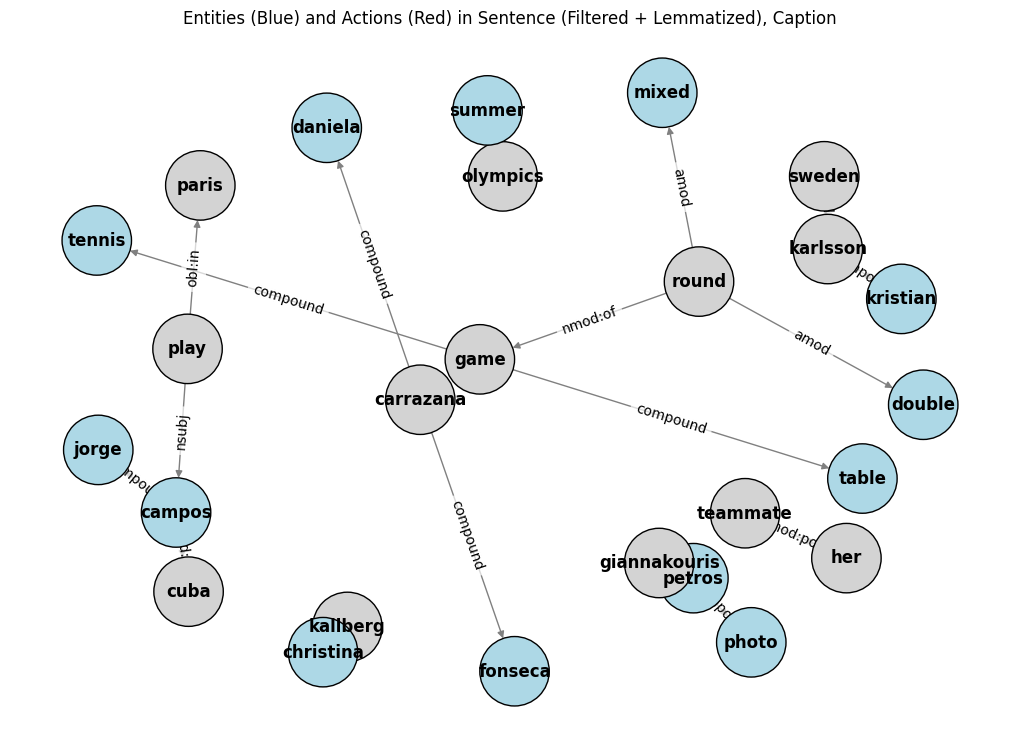

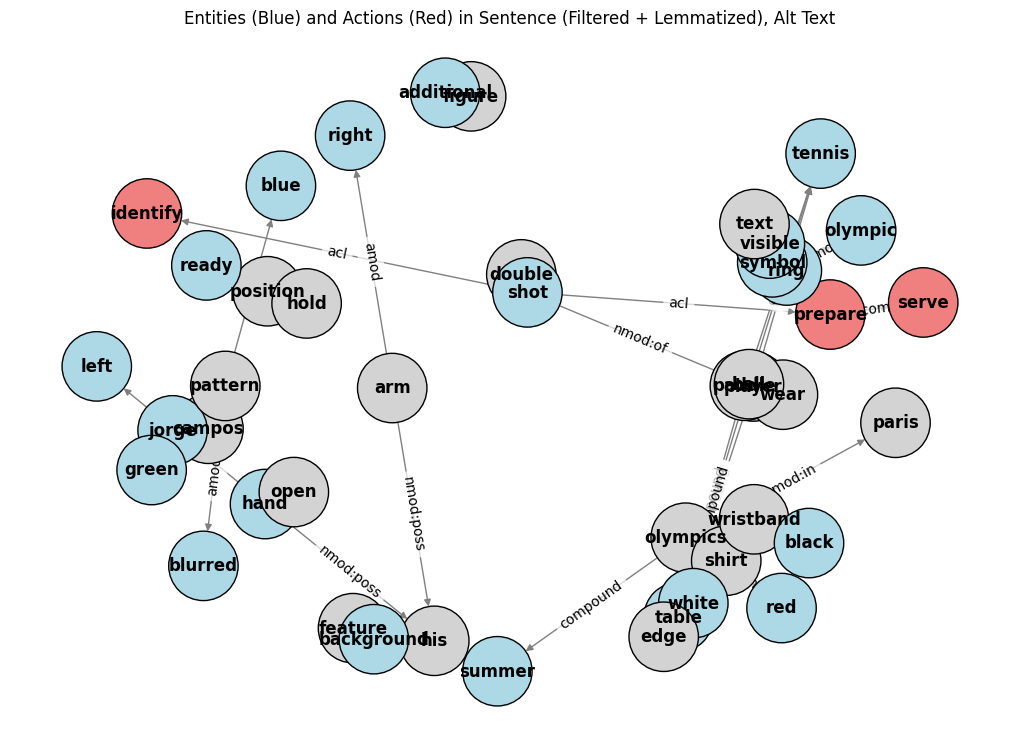

Caption: Cuba's Jorge Campos, with her teammate Daniela Fonseca Carrazana, plays against Sweden's Kristian Karlsson and Christina Kallberg during a mixed doubles round of 16 table tennis game at the 2024 Summer Olympics, Saturday, July 27, 2024, in Paris, France. (AP Photo/Petros Giannakouris)
Alt Text: Close-up shot of a table tennis player, identified as Jorge Campos, preparing to serve during the mixed doubles round of 16 at the 2024 Summer Olympics in Paris, France. His right arm is extended, holding a table tennis paddle in a ready position. The player wears a red shirt and a black wristband. His left hand is open, palm up, balancing a white table tennis ball. The Olympic rings symbol is visible on the table's edge. The background features a blurred blue and green pattern, with no visible text or additional figures.
SPICE Score: 0.06666666666666667


In [16]:
image_key = "photos_for_semantic_search_poc/1528d961348c43809a1ff3118c58411e.jpg"
get_scores(image_key, plot=True, display=False)